In [49]:
import numpy as np
import matplotlib.pyplot as plt

from constants import FIGSIZE

In [50]:
# Load all FPI voltage data into a dictionary

filename_prefix = 'data/FPI/'

# List of (file name, array name)
filename_list = [
    ('kommerzieller_HeNe/kommerzieller_HeNe.txt', 'commercial_HeNe_calibration'),
    ('kommerzieller_HeNe/polstellung1.txt', 'commercial_HeNe_pos_0'),
    ('kommerzieller_HeNe/polstellung2(=1+90deg).txt', 'commercial_HeNe_pos_1'),
    ('offener_HeNe/600mm.txt', 'open_HeNe_600mm'),
    ('offener_HeNe/800mm.txt', 'open_HeNe_800mm'),
]

# Load each file, store the array in a dictionary under the provided key
intensity_arr_dict = {
    array_name: np.loadtxt(
        fname=filename_prefix + filename,
        delimiter='\t',
        skiprows=4,
        unpack=True,
        usecols=1  # Skip first column because it only contains the indices
    )
    for filename, array_name in filename_list
}

# TBD: Normalisation? For each array or global?

In [51]:
# TODO: Correctly scale x axis, dummy array for now
wavelength_arr = np.arange(600)

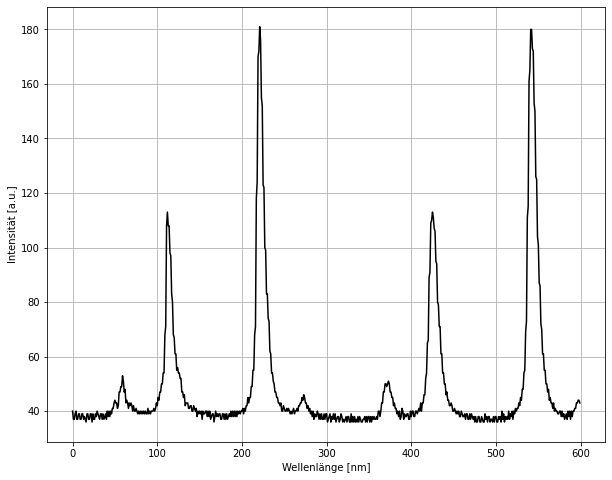

In [52]:
# Create plot for the calibration measurement
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set_xlabel('Wellenlänge [nm]')
ax.set_ylabel('Intensität [a.u.]')
ax.grid()

# Plot the spectrum
ax.plot(wavelength_arr, intensity_arr_dict['commercial_HeNe_calibration'], 'k-')

fig.savefig('figs/aufgabe2.1.svg', bbox_inches='tight')

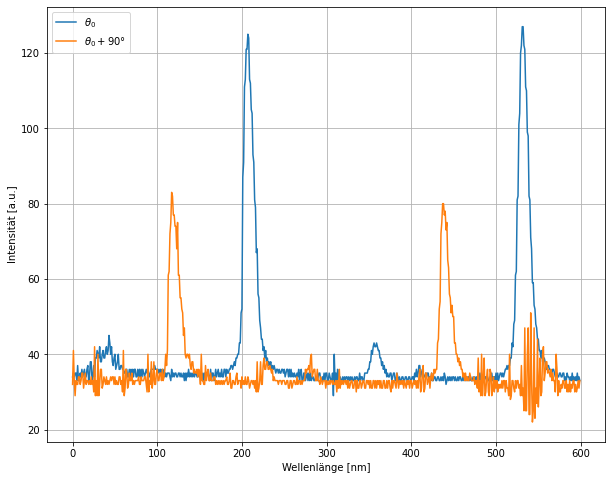

In [53]:
# Create plot for polarization analysis of commercial HeNe
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set_xlabel('Wellenlänge [nm]')
ax.set_ylabel('Intensität [a.u.]')
ax.grid()

# Plot the spectrum of both polarizer positions
# TBD: Should we add the spectrum without polarizer for comparison?
for array_name, label in zip(
        ['commercial_HeNe_pos_0', 'commercial_HeNe_pos_1'],
        ['$\\theta_0$', '$\\theta_0 + 90°$']
):
    ax.plot(wavelength_arr, intensity_arr_dict[array_name], label=label)

ax.legend()

fig.savefig('figs/aufgabe2.3.svg', bbox_inches='tight')